In [ ]:
%matplotlib inline
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import sklearn_recommender as skr
from sklearn.decomposition import TruncatedSVD

In [2]:
anime_csv='/home/bruce/Anime_ratings/datasets_571_1094_anime.csv'
users_rating='/home/bruce/Anime_ratings/rating.csv'


df_1 = pd.read_csv(anime_csv)
df_2 = pd.read_csv(users_rating)





#Merge the two dataframes above to create input dataframe for recommender systems
df = pd.merge(df_2, df_1, on="anime_id")
df=df.drop(['genre','type','episodes','rating_y','members'],axis=1)
df.head()

,user_id,anime_id,rating_x,name
0,1,20,0,Naruto
1,3,20,8,Naruto
2,5,20,6,Naruto
3,6,20,0,Naruto
4,10,20,0,Naruto


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec2f1566a0>,
      dtype=object)

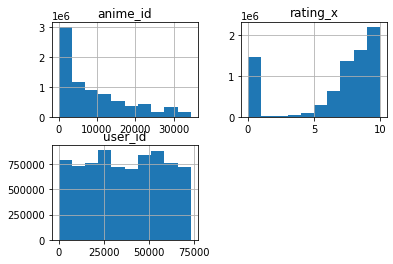

In [3]:
df.hist()

In [4]:
# df=df.dropna(axis=0,subset=['name'])
rating_count=(df.groupby(by=['name'])['rating_x'].count().reset_index().rename(columns={'rating_x':'rating_count'})[['name','rating_count']])
rating_count.head()

,name,rating_count
0,&quot;0&quot;,26
1,&quot;Aesop&quot; no Ohanashi yori: Ushi to Ka...,2
2,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hat...,782
3,&quot;Bungaku Shoujo&quot; Memoire,809
4,&quot;Bungaku Shoujo&quot; Movie,1535


In [5]:
combinedtr=df.merge(rating_count, left_on = 'name', right_on = 'name', how = 'left')
combinedtr.head()

,user_id,anime_id,rating_x,name,rating_count
0,1,20,0,Naruto,25925
1,3,20,8,Naruto,25925
2,5,20,6,Naruto,25925
3,6,20,0,Naruto,25925
4,10,20,0,Naruto,25925


In [6]:
print(rating_count['rating_count'].describe())

count    11196.000000
mean       697.903448
std       2028.947568
min          1.000000
25%          5.000000
50%         52.000000
75%        386.250000
max      39340.000000
Name: rating_count, dtype: float64


In [7]:
print(rating_count['rating_count'].quantile(np.arange(.9, 1, .01))) 


0.90    1814.50
0.91    2063.45
0.92    2377.40
0.93    2739.40
0.94    3180.30
0.95    3697.25
0.96    4411.20
0.97    5390.45
0.98    7006.80
0.99    9970.75
Name: rating_count, dtype: float64


In [8]:
popularity_threshold = 8000
popular_ratings= combinedtr.query('rating_count >= @popularity_threshold')
popular_ratings.tail()
popular_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2248684 entries, 0 to 5985025
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       int64 
 1   anime_id      int64 
 2   rating_x      int64 
 3   name          object
 4   rating_count  int64 
dtypes: int64(4), object(1)
memory usage: 102.9+ MB


In [9]:
popular_ratings

,user_id,anime_id,rating_x,name,rating_count
0,1,20,0,Naruto,25925
1,3,20,8,Naruto,25925
2,5,20,6,Naruto,25925
3,6,20,0,Naruto,25925
4,10,20,0,Naruto,25925
...,...,...,...,...,...
5985021,73499,101,9,Air,8820
5985022,73502,101,9,Air,8820
5985023,73504,101,8,Air,8820
5985024,73512,101,10,Air,8820


In [10]:
popular_ratings = popular_ratings.drop_duplicates(['user_id', 'name'])
print(popular_ratings.shape)

(2248677, 5)


In [11]:
pivottable=popular_ratings.pivot(index='user_id',columns='name',values='rating_x')
pivottable.shape

(71666, 172)

In [12]:
pivottable.head()

name,Accel World,Air,Air Gear,Akame ga Kill!,Akira,Angel Beats!,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Another,Ao no Exorcist,B Gata H Kei,...,Toradora!,Trigun,Vampire Knight,Vampire Knight Guilty,Watashi ga Motenai no wa Dou Kangaetemo Omaera ga Warui!,Yahari Ore no Seishun Love Comedy wa Machigatteiru.,Zankyou no Terror,Zero no Tsukaima,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.0,NaN,NaN,8.0,NaN,NaN,10.0,8.0,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
5,3.0,NaN,NaN,4.0,8.0,3.0,7.0,NaN,4.0,2.0,...,3.0,8.0,NaN,NaN,5.0,3.0,NaN,1.0,1.0,1.0


In [13]:
pivottable=pivottable.fillna(0)
pivottable.head()

name,Accel World,Air,Air Gear,Akame ga Kill!,Akira,Angel Beats!,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Another,Ao no Exorcist,B Gata H Kei,...,Toradora!,Trigun,Vampire Knight,Vampire Knight Guilty,Watashi ga Motenai no wa Dou Kangaetemo Omaera ga Warui!,Yahari Ore no Seishun Love Comedy wa Machigatteiru.,Zankyou no Terror,Zero no Tsukaima,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.0,0.0,0.0,8.0,0.0,0.0,10.0,8.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,0.0,0.0,4.0,8.0,3.0,7.0,0.0,4.0,2.0,...,3.0,8.0,0.0,0.0,5.0,3.0,0.0,1.0,1.0,1.0


In [14]:
X=pivottable.values.T
X.shape

(172, 71666)

In [15]:
SVD= TruncatedSVD(n_components=12,random_state=17)
matrix=SVD.fit_transform(X)
matrix.shape

(172, 12)

In [16]:
# import warnings
# warnings.filterwarnings("ignore",category=RuntimeWarning)
corr=np.corrcoef(matrix)
corr.shape

(172, 172)

### Recommendation Example

In [92]:
val=pivottable.columns
list_table=list(val)
val1=list_table.index('Dragon Ball')
val1

47

In [93]:
print(list(val[(corr[val1]>0.8)&(corr[val1]<1)]))

['Digimon Adventure', 'Dragon Ball GT', 'Dragon Ball Z', 'Pokemon']


In [94]:
val1=list_table.index('Fullmetal Alchemist')
val1

66

In [95]:
print(list(val[(corr[val1]>0.8)&(corr[val1]<1)]))

['Air Gear', 'Bleach Movie 1: Memories of Nobody', 'Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru', 'Cowboy Bebop', 'Death Note', 'Fullmetal Alchemist: Brotherhood', 'Fullmetal Alchemist: The Conqueror of Shamballa', 'Great Teacher Onizuka', 'Hellsing', 'InuYasha', 'Naruto', 'Samurai Champloo', 'Soul Eater', 'Tengen Toppa Gurren Lagann', 'Trigun']


In [96]:
val1=list_table.index('Bleach')
val1

18

In [97]:
print(list(val[(corr[val1]>0.8)&(corr[val1]<1)]))

['Ao no Exorcist', 'Bleach Movie 1: Memories of Nobody', 'Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru', 'Btooom!', 'D.Gray-man', 'Fairy Tail', 'Fullmetal Alchemist: Brotherhood', 'Hunter x Hunter (2011)', 'Kuroko no Basket', 'Magi: The Labyrinth of Magic', 'Naruto', 'Soul Eater']


In [98]:
val=pivottable.columns
list_table=list(val)
val1=list_table.index('Death Note')
val1

43

In [99]:
print(list(val[(corr[val1]>0.8)&(corr[val1]<1)]))

['Fullmetal Alchemist', 'Fullmetal Alchemist: Brotherhood', 'Hunter x Hunter (2011)', 'Kill la Kill', 'Naruto', 'Shingeki no Kyojin', 'Soul Eater', 'Tengen Toppa Gurren Lagann']
